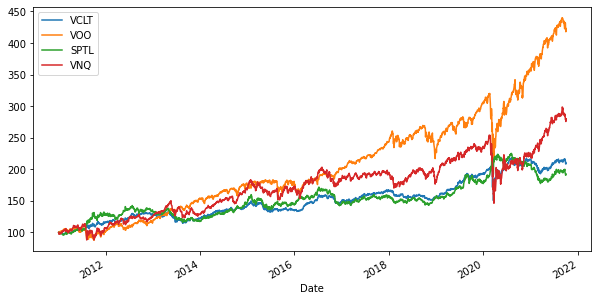

[0.         0.48128008 0.51871992 0.        ]
10.78942821542759
7.9958645288495775
[0.         0.41060843 0.58939157 0.        ]
10.227931020672248
7.78597935878067


,Fruits,Color,Value,Asset4


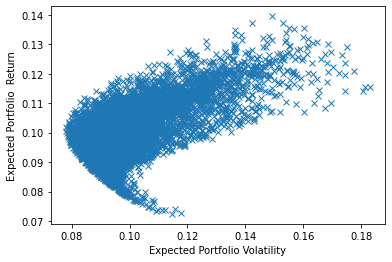

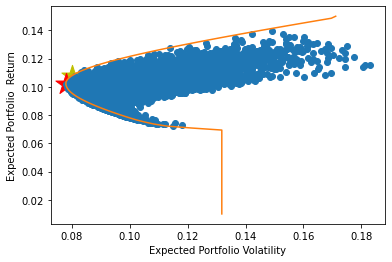

In [13]:
# %load assignmnet 1.py
#!/usr/bin/env python

# In[608]:


import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import numpy as np

import pandas_datareader.data as web
import datetime as dt

import matplotlib.pyplot as plt

from scipy.optimize import minimize 

from cvxpy import * 

import cvxopt as opt
from cvxopt import blas, solvers

np.random.seed(1)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)


# In[598]:


start = dt.datetime(2011, 1, 1)
end = dt.datetime(2021, 10, 1)

# download data 
source = 'stooq'
cbondetf = web.DataReader('VCLT', source, start, end)
us_stocksetf = web.DataReader('VOO', source, start, end)
tbond_etf = web.DataReader('SPTL', source, start, end)
reit_etf = web.DataReader('VNQ', source, start, end)

lsttojoin = [cbondetf['Close'], us_stocksetf['Close'],tbond_etf['Close'],reit_etf['Close']]

prcdf = pd.concat(lsttojoin,axis=1)

prcdf.columns = ["VCLT","VOO","SPTL","VNQ"]

rtndf = prcdf.pct_change(1).dropna()


# In[599]:


(prcdf / prcdf.iloc[0] * 100).plot(figsize=(10, 5))
plt.show()


# In[600]:


"""MC simulations to visualize risk return of our selected ETFS"""
def portfolio_returns(weights):
    return (np.sum(rtndf.mean() * weights)) * 252


# In[601]:


def portfolio_sd(weights):
    return np.sqrt(np.transpose(weights) @ (rtndf.cov() * 252) @ weights)


# In[602]:


list_portfolio_returns = []
list_portfolio_sd = []
# For loop to simulate 1000 random weight vectors (numpy array objects)
for p in range(5000):
  # Return random floats in the half-open interval [0.0, 1.0)
    weights = np.random.random(size = 4) 
    weights /= np.sum(weights) 
    list_portfolio_returns.append(portfolio_returns(weights))
    list_portfolio_sd.append(portfolio_sd(weights))
  # Convert list to numpy arrays
    port_returns = np.array(object = list_portfolio_returns)
    port_sd = np.array(object = list_portfolio_sd)


# In[603]:


## Visualzing the MC simulation

plt.figure()
plt.plot(port_sd,port_returns,'x')
plt.xlabel('Expected Portfolio Volatility')
plt.ylabel('Expected Portfolio  Return')


# In[604]:


## Maximum Sharpe ratio Portfolio
def sharpe_fun(weights):
    return - (portfolio_returns(weights) / portfolio_sd(weights))

constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bounds = tuple((0, 1) for w in weights)

equal_weights = np.array([1 / 4] * 4)

max_sr_port = minimize(fun = sharpe_fun, x0 = equal_weights, method = 'SLSQP',
                              bounds = bounds, constraints = constraint)


# In[605]:


##Weights for max sharpe ratio portfolio
sr_wgts = max_sr_port["x"]
print(sr_wgts)
## MAximum sharpe ratio portfolio 
## Expected return and volatility of Maximum sharpe ratio portfolio
max_sr_rtn = portfolio_returns(max_sr_port["x"])
print(max_sr_rtn*100)
max_sr_sd = portfolio_sd(max_sr_port["x"])
print(max_sr_sd*100)


# In[609]:


## Minimum Variance Portfolio
min_var = minimize(fun = portfolio_sd,  x0 = equal_weights, method = 'SLSQP',
                       bounds = bounds, constraints = constraint)

##Weights for minimum variance portfolio
mv_wgts = min_var["x"]
print(mv_wgts)
## MAximum sharpe ratio portfolio 
## Expected return and volatility of Maximum sharpe ratio portfolio
mv_rtn = portfolio_returns(min_var["x"])
print(mv_rtn*100)
mv_sd = portfolio_sd(min_var["x"])
print(mv_sd*100)


# In[615]:


## Efficent Frontier
constraints = ({'type': 'eq', 'fun': lambda x: portfolio_returns(x) - target}, 
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple( (0, 1) for w in weights)
# Initialize an array of target returns
target = np.linspace(start = 0.01, stop = 0.15,num = 100)
obj_sd = []
for target in target:
    min_result_object = minimize(fun = portfolio_sd, x0 = equal_weights, method = 'SLSQP',
                                   bounds = bounds, constraints = constraints)
    obj_sd.append(min_result_object['fun'])
    

obj_sd = np.array(obj_sd)

target = np.linspace(start = 0.01, stop = 0.15,num = 100)


ef = pd.DataFrame({'x':target, 'y':obj_sd})


# In[527]:


plt.figure()
plt.plot(port_sd,port_returns,'o')
plt.xlabel('Expected Portfolio Volatility')
plt.ylabel('Expected Portfolio  Return')
plt.scatter(max_sr_sd,max_sr_rtn,color="y", marker = "*", s=500)
plt.scatter(mv_sd,mv_rtn,color="red", marker = "*", s=500)
plt.plot(ef["y"],ef["x"])


# In[649]:




In [93]:
def mark_obj(weights,lam):
    return - portfolio_sd(weights) - lam * (portfolio_returns(weights))

constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bounds = tuple((0, 1) for w in weights)

equal_weights = np.array([1 / 4] * 4)

lamgrd = np.linspace(start = 0,stop = 5, num = 100)
obj_sd1 = []
mark_weights = []
for lam in lamgrd:
    optfun = lambda x: mark_obj(x,lam)
    mark = minimize(fun = optfun, x0 = equal_weights, method = 'SLSQP',
                                   bounds = bounds, constraints = constraint)
    obj_sd1.append(mark['fun'])
    mark_weights.append((mark["x"]))
    
    
    
obj_sd1 = np.array(obj_sd1)
lamgrd = np.linspace(start = 0.1, stop = 1,num = 100)

min_mark = pd.DataFrame({'lambda':lamgrd,  "weights": mark_weights})





In [94]:
# In[613]:


"""Considering 100 risk aversion parameters from 0.1 to 1, 0.1 being the lowest and 1 being the highest"""
'''Portfolio weights for most risk averse investor are '''
min_mark.loc[min_mark['lambda']==0.1]


# In[594]:


min_mark.loc[min_mark['lambda']==1,'weights']


# In[662]:

min_mark['weights']

0     [0.0, 2.4424906541753444e-15, 0.0, 0.999999999...
1     [1.3461454173580023e-15, 0.0, 4.66606812078343...
2               [0.0, 2.9698465908722937e-15, 0.0, 1.0]
3     [1.790234627208065e-15, 1.1102230246251565e-16...
4     [6.38378239159465e-16, 1.6653345369377348e-16,...
                            ...                        
95                                 [0.0, 1.0, 0.0, 0.0]
96    [0.0, 0.9999999999999986, 0.0, 1.7486012637846...
97    [0.0, 0.9999999999999998, 0.0, 1.7208456881689...
98              [0.0, 1.0, 0.0, 2.0816681711721685e-15]
99    [1.4432899320127035e-15, 0.9999999999999987, 1...
Name: weights, Length: 100, dtype: object